In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.notebook import tqdm

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Make the code reproducible
SEED = 42

# Load the data

In [2]:
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'delta_videos', 'activity', 'views'])

# Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [3]:
df_all_declines = df_all_declines_original.copy()

# If the decline is longer than 4 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 4 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 4 * 4

# Add the decline outcome
df_all_declines['Recovered'] = df_all_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_all_declines['Category'] = df_all_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

# Add the delta videos at the start of the decline
df_all_declines['Delta_videos'] = df_data_processed.loc[decline_index, 'delta_videos'].values

# Add the channel's subs at the start of the decline
df_all_declines['Views_start'] = df_data_processed.loc[decline_index, 'views'].values

df_all_declines.head()

,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Delta_videos,Views_start
0,UCi8IX8CVCHRKiLV_eCWEKNA,20,False,117,137,People & Blogs,32974.875000,1,0.0,1.842075e+06
1,UCi8IX8CVCHRKiLV_eCWEKNA,28,False,190,218,People & Blogs,150182.875000,3,2.0,1.236850e+07
2,UCW4jUKddkdTJwl3EFlc8ZMQ,13,True,218,231,Film and Animation,12939.125000,0,0.0,4.470020e+06
3,UC_hZX0wqyjq3CabYF25ol8Q,18,False,224,242,Gaming,16797.444444,4,1.0,5.939868e+06
4,UC-TDzpXxJndgBvyX4dZXVzA,29,False,172,201,Music,22794.200000,0,0.0,3.953500e+06


# How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we make the dataset balanced by using a matched observational study.

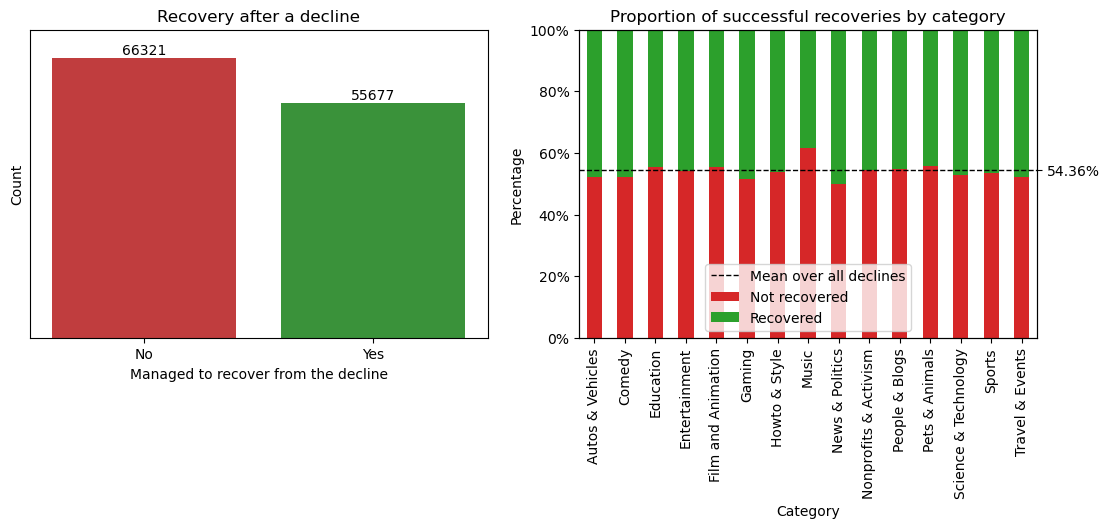

In [4]:
plot_groups_by_categories(df_all_declines)

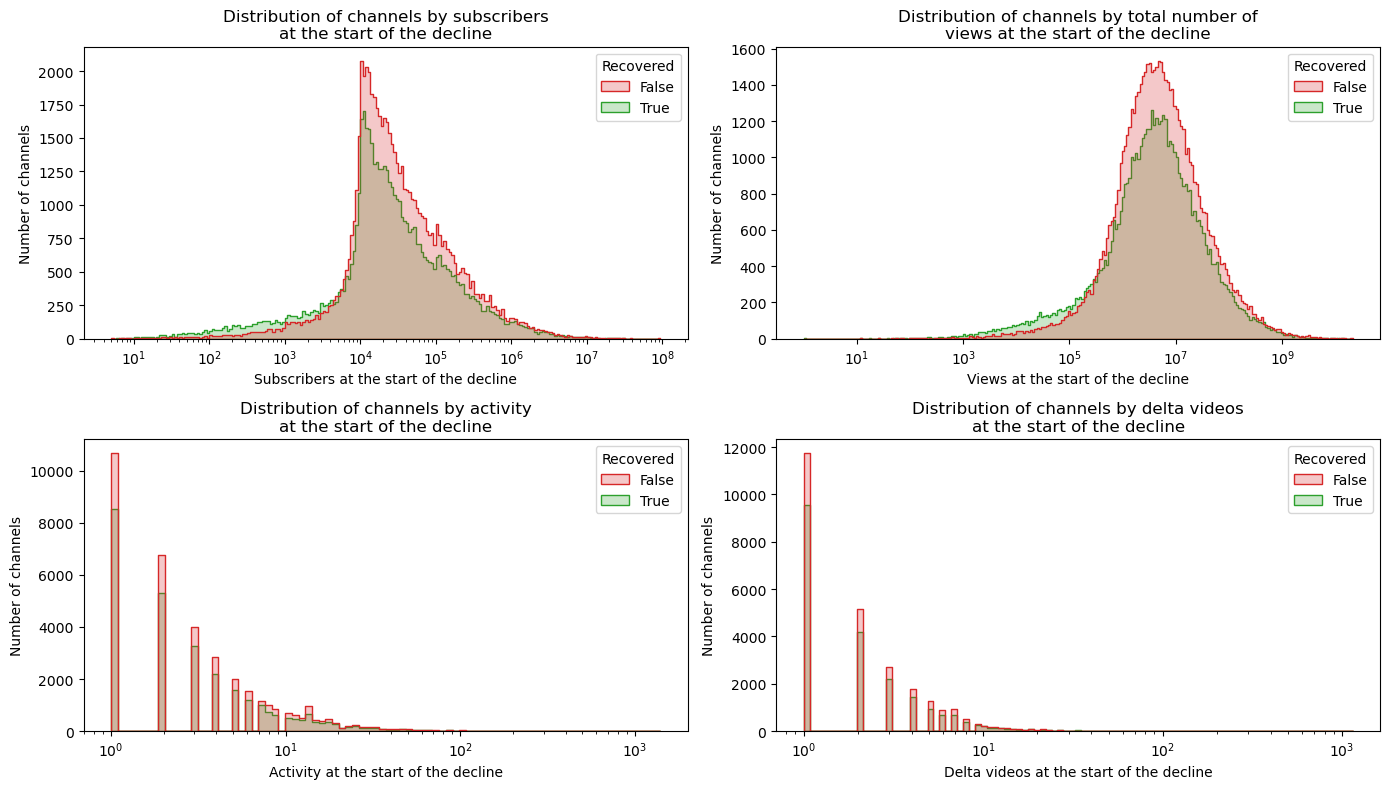

In [5]:
plot_group_distributions(df_all_declines)

Since we can observe that some features are not balanced between the treatment and control groups, especially views and subscribers at the start of the decline, we will perform matching between the two groups.

In [6]:
print(df_all_declines['Recovered'].value_counts())
print(f"\nTotal number of declines: {len(df_all_declines)}")

Recovered
False    66321
True     55677
Name: count, dtype: int64

Total number of declines: 121998


Considering the size of the dataset, we use random sampling to ease the matching's computation.

To check that sampling does not mess with the distribution of recoveries, we plot them depending on the sampling proportion.

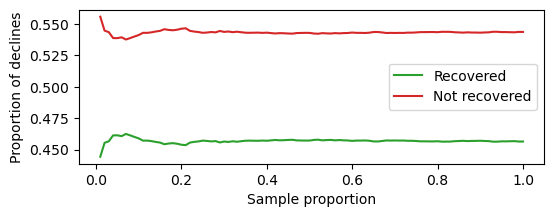

In [7]:
plot_sampling_rates(df_all_declines, SEED)

We choose to sample 30% of the data since the distribution of recoveries is left mostly unchanged, and it allows to keep a representative sample of the data.

In [8]:
df_sampled = df_all_declines.sample(frac=0.3, replace=False, random_state=SEED)

print(df_sampled['Recovered'].value_counts())
print(f"\nTotal number of declines after sampling: {len(df_sampled)}")

Recovered
False    19897
True     16702
Name: count, dtype: int64

Total number of declines after sampling: 36599


# YouTuber reactions

As we want to find the best ways to deal with a decline depending on the situation, we then take a look at how the YouTubers reacted to the decline, and what methods proved effective.

### Adding the reaction metrics whose impact we want to measure

In [9]:
# Load the videos around the declines, from week (decline start - decline duration) to week (decline end)
videos_around_declines = pd.read_csv('data/videos_around_declines.csv')

# Add the declines with the indices of the corresponding videos
df_sampled = get_sampled_declines_with_videos(df_sampled, videos_around_declines)

# Augment the data with the video stats : videos per week and mean video duration, before and during the declines
df_sampled = add_video_stats(df_sampled, videos_around_declines)

# Drop the indices of the videos, they are not needed anymore
df_sampled = df_sampled.drop(['Videos_before', 'Videos_after'], axis=1)

df_sampled.head()

Sampled declines with videos loaded from file.


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Delta_videos,Views_start,Videos_per_week_before,Videos_per_week_after,Mean_duration_before,Mean_duration_after
0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.0,1.753062e+07,0.950000,0.700000,566.894737,986.642857
1,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,0.0,2.758465e+07,3.357143,2.142857,1095.446809,2527.900000
2,UCWmJyyUVP6AoR79IA9MTNpQ,30,False,192,222,People & Blogs,14676.662037,0,0.0,5.199927e+06,0.033333,0.033333,242.000000,235.000000
3,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,2.0,3.935174e+06,2.071429,2.500000,721.931034,544.628571
4,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,1.0,2.818956e+06,1.600000,1.000000,921.666667,672.133333


### Propensity score matching

Seeing that the declines do not have the same distribution on their features, we perform propensity score matching to balance the treatment and control groups.

In [ ]:
# Try to load the matches from the file, otherwise compute them
matches = get_matches(df_sampled)

print("Matches :", matches)

# Flatten
matches = [index for match in matches for index in match]

# Get the matched declines
df_matched = df_sampled.loc[matches]

File not found, computing the matches...
Optimization terminated successfully.
         Current function value: 0.013070
         Iterations 14
Matching treatment and control
Computing similarities
Computing matches


After the propensity score matching, we can compare the distributions to the ones that we had before.

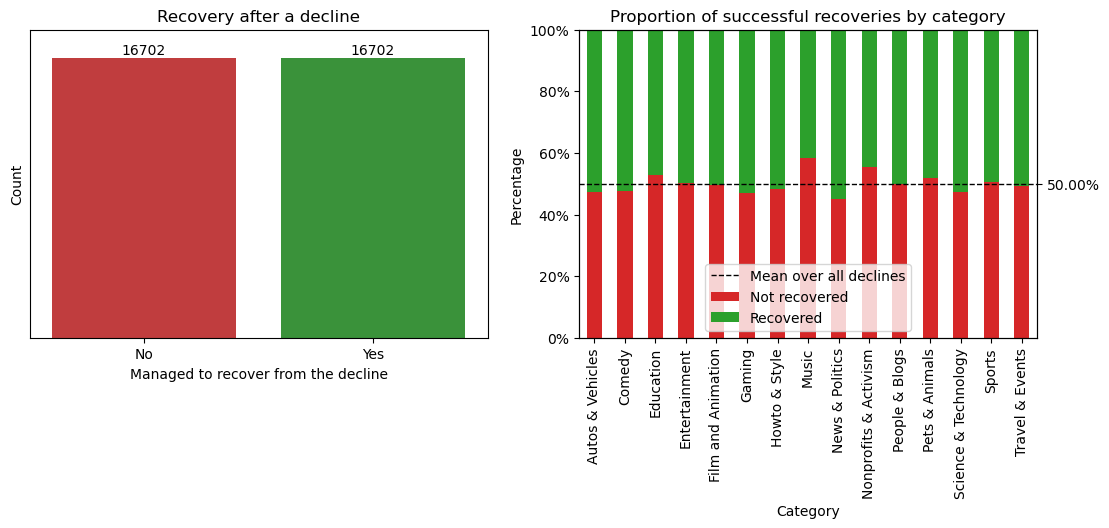

In [ ]:
plot_groups_by_categories(df_matched)

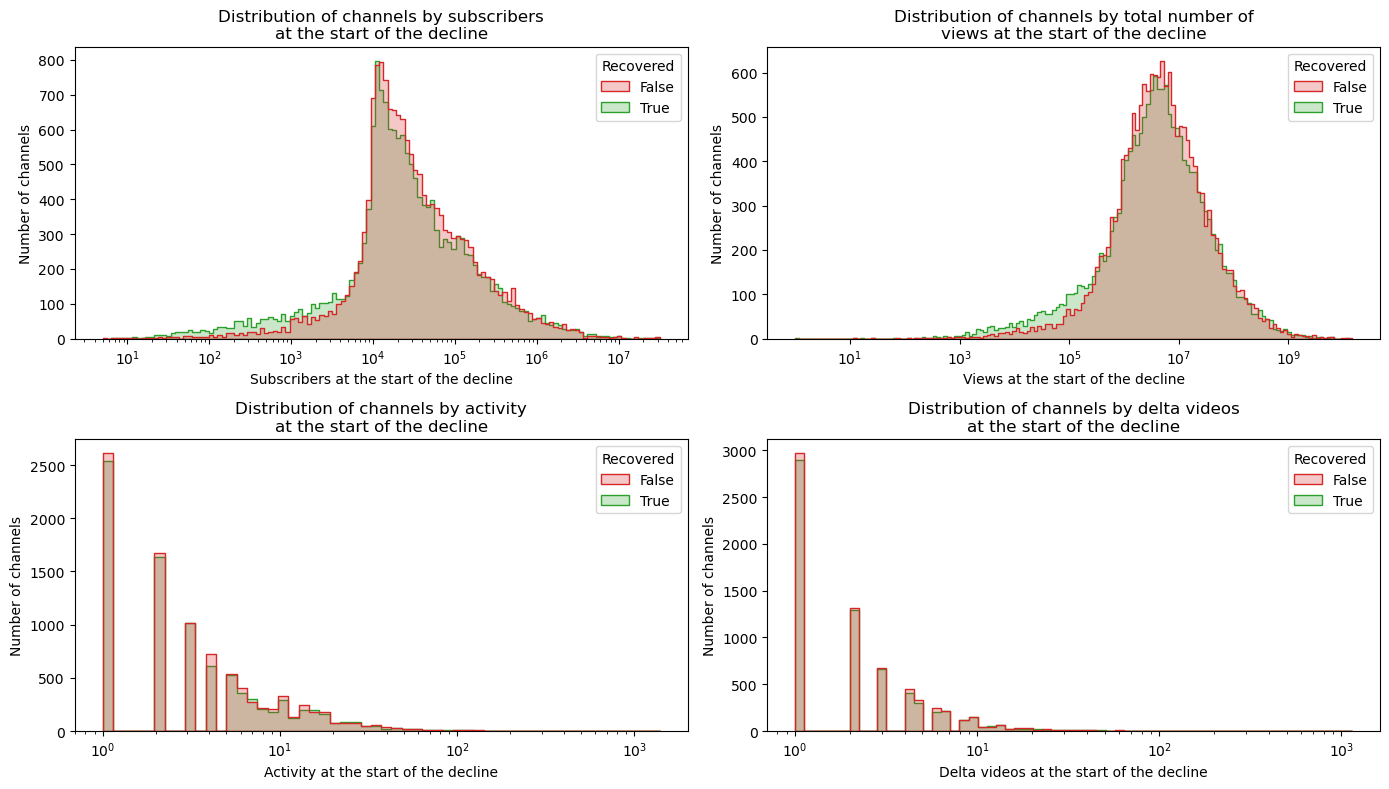

In [ ]:
plot_group_distributions(df_matched)